## Семинар 4: "Сверточные сети"

ФИО: Шахвалиева Юлиана Сергеевна

In [13]:
import numpy as np
#from sklearn.datasets import fetch_mldata
#from sklearn.model_selection import train_test_split
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [14]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    for i in range(signal.shape[0]-kernel.shape[0]+1):
        signal_convolved[i] = np.sum(signal[i : i + kernel.shape[0]] * kernel[::-1])
    return signal_convolved

In [15]:
from scipy.signal import convolve

Проверим правильность реализации, сравнив с реализацией из scipy

In [16]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

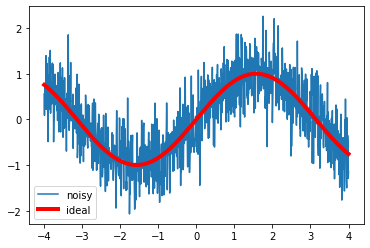

In [17]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)
plt.show()

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [18]:
kernel_size = 5
kernel = np.ones(kernel_size)/kernel_size
denoised_signal = convolve(noisy_signal, kernel, 'same')

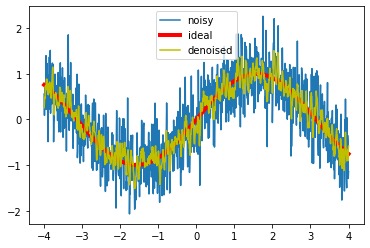

In [19]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)
plt.show()

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [20]:
### YOUR CODE HERE #####
best_kernel_size = None
min_error = None
for kernel_size in range(1, 2000):
    kernel = np.ones(kernel_size)/kernel_size#YOUR CODE HERE
    denoised_signal = convolve(noisy_signal, kernel, 'same')
    
    mse = ((denoised_signal - signal)**2).mean()
    if min_error is None or mse < min_error:
        min_error = mse
        best_kernel_size = kernel_size
best_kernel_size

59

In [21]:
kernel_size = 1000
kernel = np.ones(kernel_size)/kernel_size#YOUR CODE HERE
denoised_signal = convolve(noisy_signal, kernel, 'same')

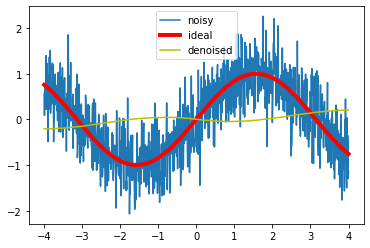

In [23]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)
plt.show()

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

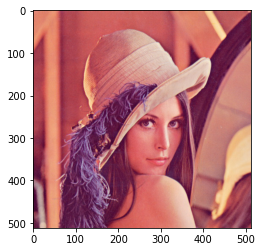

In [52]:
image = plt.imread('./lena.jpg')
plt.imshow(image)
plt.show()

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [53]:
color_to_bw_simple = np.array([1/3, 1/3, 1/3])
color_to_bw = np.array([0.2125, 0.7154, 0.0721])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

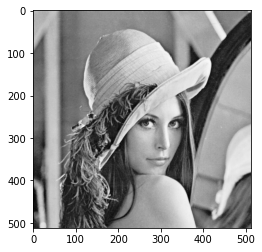

In [54]:
from scipy.signal import convolve2d

bw_image = convolve(image.flatten(), color_to_bw_simple, "same")[::3].reshape(image.shape[:-1])##### YOUR CODE HERE #####
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)
plt.show()

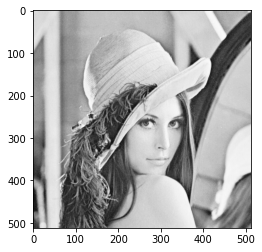

In [55]:
from scipy.signal import convolve2d

bw_image = convolve(image.flatten(), color_to_bw, "same")[::3].reshape(image.shape[:-1])##### YOUR CODE HERE #####
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)
plt.show()

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

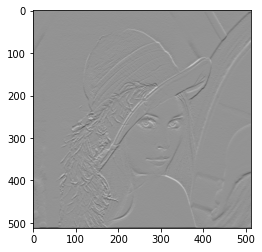

In [59]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)
plt.show()

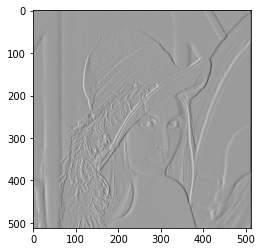

In [60]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)
plt.show()

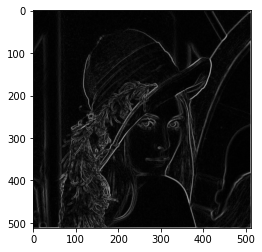

In [61]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)
plt.show()

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [62]:
#signal - n x m x c
#kernel - c x 1 x 1 x d
#signal_out - n x m x d

def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    assert signal.shape[-1] == kernel.shape[0]
    
    signal_out = np.zeros(signal.shape[:-1] + (kernel.shape[-1],))
    
    for j in range(kernel.shape[0]):
        for k in range(kernel.shape[-1]):
            signal_out[:,:,k] += convolve2d(signal[:, :, j], kernel[j, :, :, k], "same")

    return signal_out

In [63]:
def t_convolve_bank_naive(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    assert signal.shape[-1] == kernel.shape[0]
    
    signal_out = np.zeros(signal.shape[:-1] + (kernel.shape[-1],))
    
    for i in range(signal.shape[0]- kernel.shape[1]):
        for j in range(signal.shape[1] - kernel.shape[2]):
            for k in range(kernel.shape[-1]):
                signal_out[i, j, k] = np.sum(signal[i:i+kernel.shape[1], j:j+kernel.shape[2]] * kernel[:,:,:,k].transpose(1,2,0))

    return signal_out

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

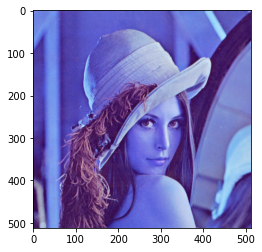

In [65]:
convert_kernel = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
]).reshape(3, 1, 1, 3)

convert_kernel_bgr = t_convolve_bank(image, convert_kernel)
plt.imshow(convert_kernel_bgr.astype('uint8'))
plt.show()

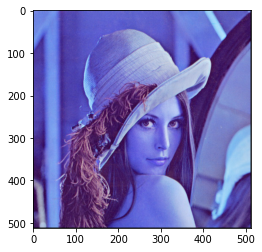

In [66]:
convert_kernel = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
]).reshape(3, 1, 1, 3)

convert_kernel_bgr = t_convolve_bank_naive(image, convert_kernel)
plt.imshow(convert_kernel_bgr.astype('uint8'))
plt.show()

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

In [ ]:
##### YOUR CODE HERE #####
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [78]:
def pooling(image, w=2, func=np.max):

    image_out = np.zeros((image.shape[0]//w, image.shape[1]//w, image.shape[2]))
    
    for i in range(0, image.shape[0]-w, w):
        for j in range(0, image.shape[1]-w, w):
            image_out[i//w, j//w, :] = func(image[i : i + w, j : j + w, :], axis = (0, 1))
            
    return image_out

def maxpool(image, w=2):
    assert(image.ndim == 3)
    ##### YOUR CODE HERE #####
    pooling(image, w, np.max)

def medianpool(image, w=2):
    assert(image.ndim == 3)
    ##### YOUR CODE HERE #####
    pooling(image, w, np.median)


Как и в первой части, посмотрим сначала как эта операция влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

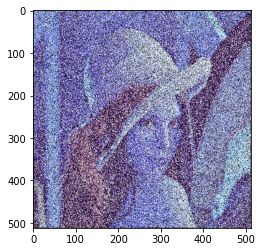

In [79]:
noised_image = convert_kernel_bgr.copy()

p = 0.7

noised_image[np.random.randn(noised_image.shape[0], noised_image.shape[1]) > p] = (0, 0, 0)
noised_image[np.random.randn(noised_image.shape[0], noised_image.shape[1]) > p] = (255, 255, 255)

plt.imshow(noised_image.astype('uint8'))
plt.show()

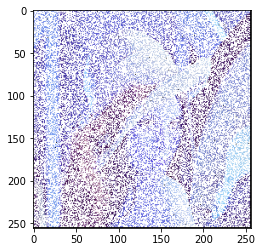

In [83]:
denoised_image = pooling(noised_image, w=2, func=np.max)
plt.imshow(denoised_image.astype('uint8'))
plt.show()

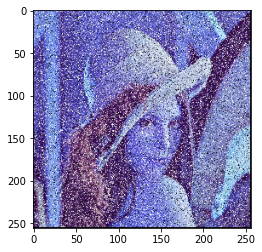

In [81]:
denoised_image = pooling(noised_image, w=2, func=np.median)
plt.imshow(denoised_image.astype('uint8'))
plt.show()

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

С задачей избавления от шума "Соль и перец" лучше справился average-pooling. Это произошло потому, что он сглаживал соседние пиксели, тем самым добавляя цвет туда, где его не хватает. Max-pooling не справился с этой задачей, так он выбирал постоянно максимальный элемент, то есть оставлял только белые пиксели.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [84]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [153]:
class ConvClassifier(nn.Module):
    def __init__(self, start_channels, image_size, mode):
        super().__init__()
        self.layers = nn.Sequential(*self.get_modules(start_channels, image_size, mode))

    def get_modules(self, start_channels, image_size, mode):
        layers = [nn.Conv2d(start_channels, 8, 3, padding=1), nn.ReLU()]

        if mode == 1:
            layers.append(nn.MaxPool2d(2))
            layers.append(nn.Conv2d(8, 16, 3, padding=1))
            layers.append(nn.ReLU())
        elif mode == 2:
            layers.append(nn.Conv2d(8, 16, 3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            layers.append(nn.Conv2d(16, 32, 3, padding=1))
        else:
            raise Exception('Parameter for mode is not exists. Available values are 1 and 2.')

        layers.append(nn.Flatten())
        layers.append(nn.Linear(image_size // 2 * image_size // 2 * 16 * mode, 10))
        layers.append(nn.LogSoftmax(dim=1))

        return layers

    def forward(self, x):
        return self.layers(x)

In [156]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train')
            plt.plot(test_accuracy_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

Epoch 4... (Train/Test) NLL: 0.089/0.074	Accuracy: 0.974/0.977


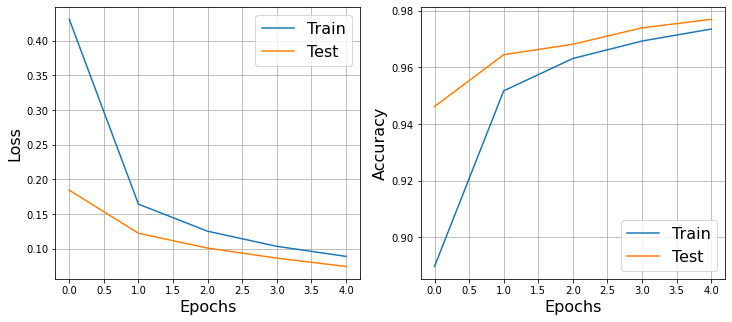

In [160]:
network_1 = ConvClassifier(start_channels=1, image_size=28, mode=1)
train(network_1, 5, 1e-4)

Epoch 4... (Train/Test) NLL: 0.059/0.056	Accuracy: 0.982/0.980


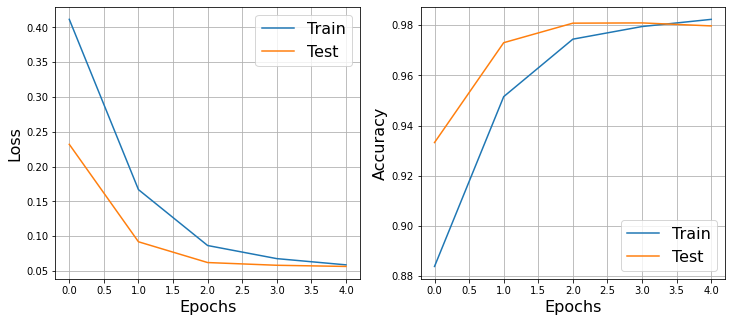

In [161]:
network_2 = ConvClassifier(start_channels=1, image_size=28, mode=2)
train(network_2, 5, 1e-4)

Полученная точность классификации на тестовой выборке:
*   97,6% - полносвязная сеть (ReLU);
*   97,7% - сверточная сеть с 1 архитектурой;
*   98% - сверточная сеть со 2 архитектурой.

Как видно, сверточные нейронный сети показали качество немного выше, чем полносвязная сеть. Стоит учесть тот факт, что полносвязной сети для достижения подобного результата понадобилось 20 эпох обучения, в то время как сверточной сети хватило 5 эпох.

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

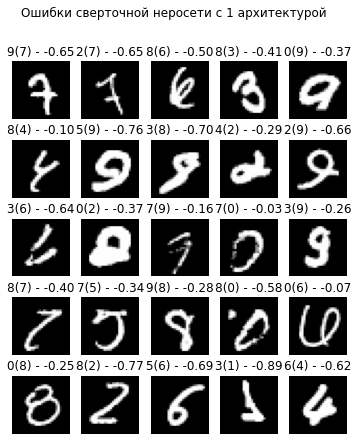

In [171]:
bank = []
for img, target in test_loader:
    y = network_1(img)
    y_pred = y.detach().argmax(-1)
    for i in range(img.shape[0]):
        if target[i] != y_pred[i]:
            bank.append((img[i].reshape(28, 28), "{}({}) - {:.2f}".format(y_pred[i], target[i], y[i][y_pred[i]].detach().numpy())))

plt.figure(figsize=(6, 7)).suptitle('Ошибки сверточной неросети с 1 архитектурой')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(bank[i][0], cmap=plt.cm.Greys_r)
    plt.title(bank[i][1])
    plt.axis('off')

plt.show()

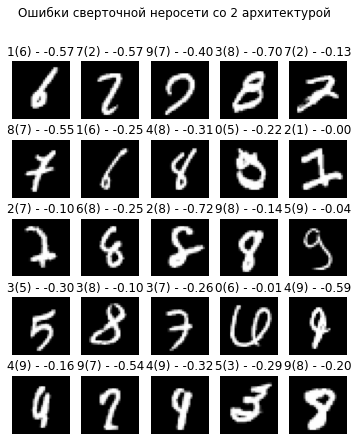

In [172]:
bank = []
for img, target in test_loader:
    y = network_2(img)
    y_pred = y.detach().argmax(-1)
    for i in range(img.shape[0]):
        if target[i] != y_pred[i]:
            bank.append((img[i].reshape(28, 28), "{}({}) - {:.2f}".format(y_pred[i], target[i], y[i][y_pred[i]].detach().numpy())))

plt.figure(figsize=(6, 7)).suptitle('Ошибки сверточной неросети со 2 архитектурой')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(bank[i][0], cmap=plt.cm.Greys_r)
    plt.title(bank[i][1])
    plt.axis('off')

plt.show()

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [211]:
class ConvClassifier_my(nn.Module):
    def __init__(self, start_channels, image_size):
        super().__init__()
        self.layers = nn.Sequential(*self.get_modules(start_channels, image_size))

    def get_modules(self, start_channels, image_size):
        layers = [nn.Conv2d(start_channels, 16, 3, padding=1), 
                  nn.ReLU(),
                  nn.Conv2d(16, 64, 3, padding=1),
                  nn.ReLU(),
                  nn.MaxPool2d(2),
                  nn.Flatten(),
                  nn.Linear(image_size // 2 * image_size // 2 * 64, 10),
                  nn.Softmax(dim=1)]
        return layers

    def forward(self, x):
        return self.layers(x)

Epoch 4... (Train/Test) NLL: -0.979/-0.979	Accuracy: 0.983/0.982


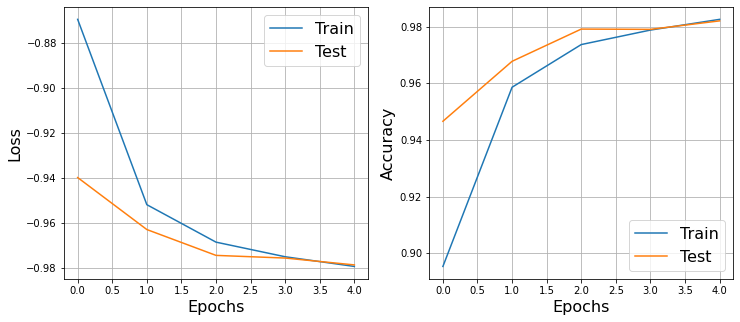

In [212]:
network_my = ConvClassifier_my(start_channels=1, image_size=28)
train(network_my, 5, 1e-4)

Да, мне удалось улучшить результат на тестовой выборке. Качество классификации на тестовой выборке: 98,2%

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: